In [3]:
import numpy as np
import matplotlib.pyplot as plt
import PIL

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy

from PIL import Image

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-10-01 06:31:37,915: Credentials are already in use. The existing account in the session will be replaced.


In [4]:
# Loading our image in the Quantum State
test_image = Image.open('test_4x4_image.tif')
np_test_image = np.array(test_image)

# We need to do this so that we take only a single channel of the color data in the .tif image
test_image_final = []
for row in np_test_image:
    for pixel in row:
        test_image_final.append( pixel[0] / 256)

np_test_image = np.array(test_image_final)

np_test_image = np_test_image.reshape((4,4))
print(np_test_image)


[[0.8125     0.84765625 0.86328125 0.8515625 ]
 [0.88671875 0.89453125 0.22265625 0.8984375 ]
 [0.2890625  0.890625   0.49609375 0.8984375 ]
 [0.43359375 0.89453125 0.38671875 0.4375    ]]


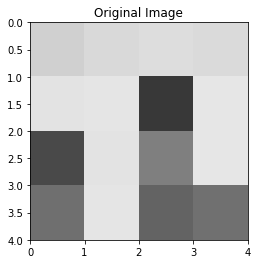

In [5]:
# Function to plot our image
def plot_image4x4(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 4, 4, 0], vmin=0, vmax=1, cmap='gray')
    plt.show()
    
plot_image4x4(np_test_image, "Original Image")   

[[0.2778443  0.2898664  0.29520956 0.29120219]
 [0.3032243  0.30589588 0.07614002 0.30723167]
 [0.09884845 0.30456009 0.16964532 0.30723167]
 [0.14827268 0.30589588 0.1322432  0.14960847]]


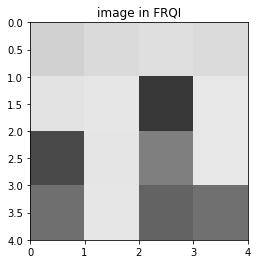

In [6]:
# We need to normalize our input image before passing it as the input quantum state.
def normalize(array):
    rms = np.sqrt(np.sum(np.sum(array**2)))
    ret_array = []
    for i in array:
        ret_array.append( (i * (1/rms)) )
    
    npret_array = np.array(ret_array)
    return npret_array

# The normalized image is too dark, so we brighten it with this method
def plot_image4x4_brightened(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 4, 4, 0], vmin=0, vmax=0.34, cmap='gray')
    plt.show()
    

np_test_image_normalized = normalize(np_test_image)
print(np_test_image_normalized)

plot_image4x4_brightened(np_test_image_normalized, 'image in FRQI')

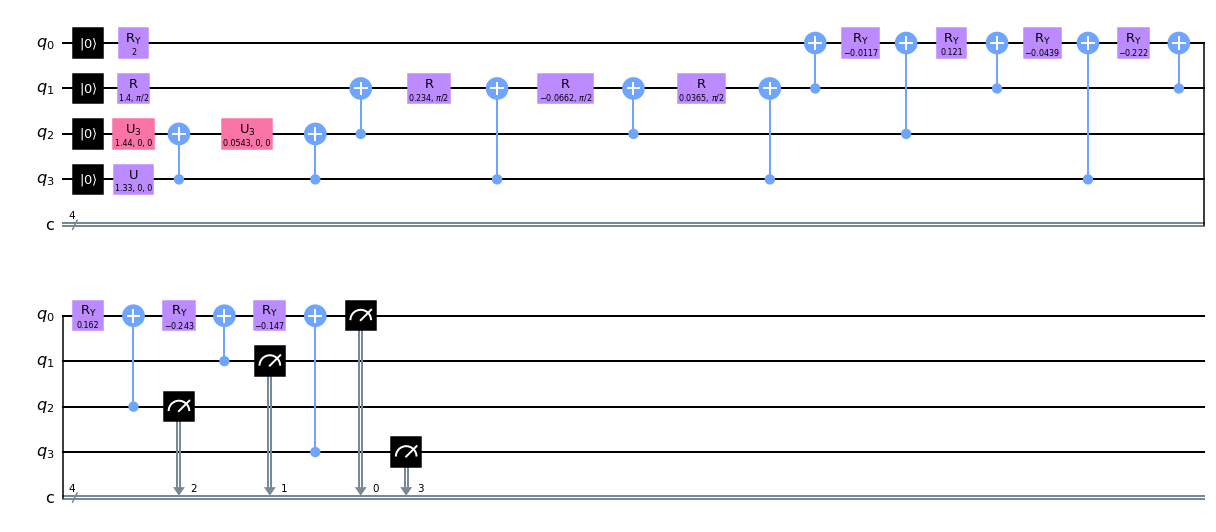

In [16]:
# Let's see how well FRQI works in determining the image probabilistically:
qc_image = QuantumCircuit(4,4)

qc_image.initialize(np_test_image_normalized.reshape(16))

qc_image.measure(range(4), range(4))

qc_image = qc_image.decompose().decompose().decompose().decompose().decompose().decompose().decompose()

qc_image.draw()

{'1000': 33, '1110': 82, '1111': 98, '1010': 120, '0001': 330, '1011': 378, '0010': 364, '0111': 380, '0011': 350, '0000': 310, '1101': 389, '0110': 20, '0100': 358, '1001': 355, '1100': 79, '0101': 354}


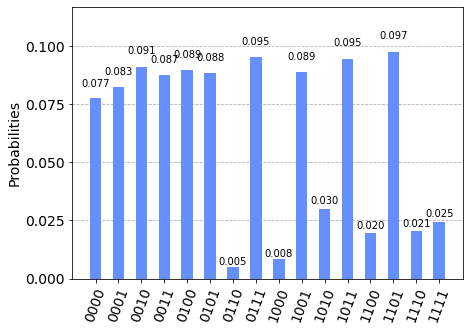

In [17]:
#Firstly, with a simulator:
simulator = Aer.get_backend('aer_simulator')
qc_image_transpiled = transpile(qc_image, simulator)

qc_image_sim_result = simulator.run(qc_image_transpiled, shots=4000).result()
qc_image_sim_counts = qc_image_sim_result.get_counts()

print(qc_image_sim_counts)
plot_histogram(qc_image_sim_counts)

[[0.27838822 0.28722813 0.30166206 0.29580399]
 [0.29916551 0.2974895  0.07071068 0.3082207 ]
 [0.09082951 0.29790938 0.17320508 0.30740852]
 [0.14053469 0.31184932 0.14317821 0.15652476]]


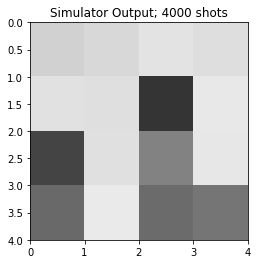

In [18]:
# We need to convert this python dict into a pixel array, which we do like so:
get_bin = lambda x, n: format(x, 'b').zfill(n)

sim_image_counts = [qc_image_sim_counts[get_bin(i,4)] for i in range(2**4)] 

np_sim_image_counts = np.array(sim_image_counts)
np_sim_image_counts = np_sim_image_counts / 4000
# We need to square root evvery vale to determine the amplitudes
np_sim_image_counts = np.sqrt(np_sim_image_counts)
np_sim_image_counts = normalize(np_sim_image_counts)

np_sim_image_counts = np_sim_image_counts.reshape((4,4))

print(np_sim_image_counts)

plot_image4x4_brightened(np_sim_image_counts, "Simulator Output; 4000 shots")

In [20]:
# Now, let's run this on Quantum Hardware:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (4) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

qc_image_transpiled = transpile(qc_image, backend, optimization_level=3)
job_qc_image = backend.run(qc_image_transpiled)
job_monitor(job_qc_image, interval=2)

ibmqfactory.load_account:WARNING:2022-09-16 18:08:08,038: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_quito
Job Status: job has successfully run


ibmqfactory.load_account:WARNING:2022-09-16 18:40:02,755: Credentials are already in use. The existing account in the session will be replaced.


{'0000': 454, '0001': 515, '0010': 335, '0011': 311, '0100': 338, '0101': 248, '0110': 148, '0111': 417, '1000': 129, '1001': 283, '1010': 145, '1011': 226, '1100': 86, '1101': 236, '1110': 75, '1111': 54}


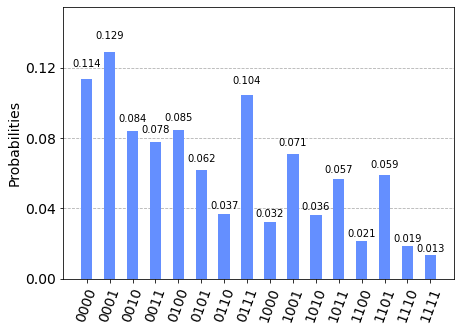

In [22]:
# The Job is sent to IBMQ_Quito, Job_ID:6324bb91ebe261aa0ceef3ab
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
quito = provider.get_backend('ibmq_quito')
quito_image_counts = quito.retrieve_job('6324bb91ebe261aa0ceef3ab').result().get_counts()

print(quito_image_counts)
plot_histogram(quito_image_counts)

[[0.33689761 0.3588175  0.28939592 0.27883687]
 [0.29068884 0.24899799 0.19235384 0.32287769]
 [0.17958285 0.26598872 0.19039433 0.23769729]
 [0.14662878 0.24289916 0.13693064 0.1161895 ]]


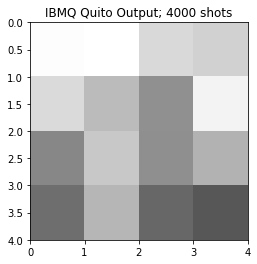

In [23]:
# We need to convert this python dict into a pixel array, which we do like so:
get_bin = lambda x, n: format(x, 'b').zfill(n)

quito_image_counts = [quito_image_counts[get_bin(i,4)] for i in range(2**4)] 

np_quito_image_counts = np.array(quito_image_counts)
np_quito_image_counts = np_quito_image_counts / 4000
# We need to square root evvery vale to determine the amplitudes
np_quito_image_counts = np.sqrt(np_quito_image_counts)
np_quito_image_counts = normalize(np_quito_image_counts)

np_quito_image_counts = np_quito_image_counts.reshape((4,4))

print(np_quito_image_counts)

plot_image4x4_brightened(np_quito_image_counts, "IBMQ Quito Output; 4000 shots")